## Setup

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from google.colab import drive
import pathlib
import random
import glob
import matplotlib.pyplot as plt

print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.8.2
/device:GPU:0
Num GPUs Available:  1


In [2]:
drive.mount('/content/gdrive')
folder = '/content/gdrive/My Drive/Colab Notebooks/cnn_garage/dataset'
os.listdir(folder)

Mounted at /content/gdrive


['open', 'close']

In [3]:
data_dir = tf.keras.utils.get_file(origin=folder, fname=folder)
data_dir = pathlib.Path(data_dir)

print(data_dir)

/content/gdrive/My Drive/Colab Notebooks/cnn_garage/dataset


In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f"Images in the dataset: {image_count}")

Images in the dataset: 823


In [5]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='binary')

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='binary')

class_names = train_ds.class_names
print(f"Classes: {class_names}")

Found 823 files belonging to 2 classes.
Using 659 files for training.
Found 823 files belonging to 2 classes.
Using 164 files for validation.
Classes: ['close', 'open']


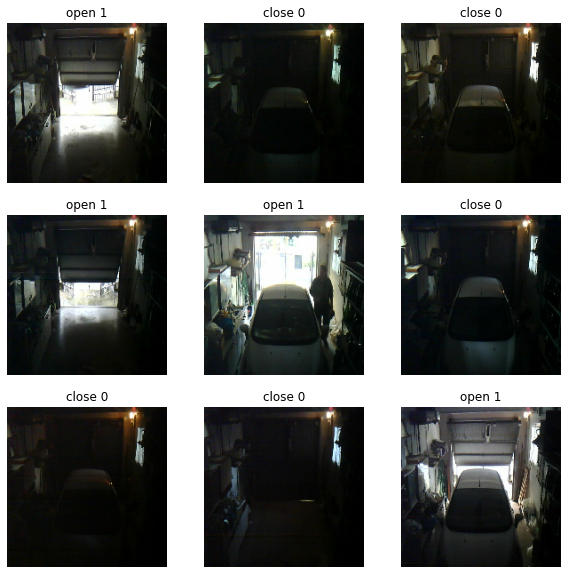

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(labels[i])]+ ' ' + str(int(labels[i])))
    plt.axis("off")

In [7]:
# check dimensions
(image_batch, labels_batch) = next(iter(train_ds))
print(image_batch.shape)
print(labels_batch.shape)

(32, 180, 180, 3)
(32, 1)


In [8]:
# normalize images
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print("Min, Max:", np.min(first_image), np.max(first_image))

Min, Max: 0.0 1.0


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model definition

In [10]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

## Training

In [11]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5
)

Epoch 1/5
21/21 [==============================] - 179s 8s/step - loss: 0.3526 - accuracy: 0.8452 - val_loss: 0.1678 - val_accuracy: 0.9756
Epoch 2/5
21/21 [==============================] - 1s 33ms/step - loss: 0.1580 - accuracy: 0.9363 - val_loss: 0.1404 - val_accuracy: 0.9634
Epoch 3/5
21/21 [==============================] - 1s 30ms/step - loss: 0.1478 - accuracy: 0.9378 - val_loss: 0.1075 - val_accuracy: 0.9756
Epoch 4/5
21/21 [==============================] - 1s 30ms/step - loss: 0.1504 - accuracy: 0.9363 - val_loss: 0.0993 - val_accuracy: 0.9695
Epoch 5/5
21/21 [==============================] - 1s 30ms/step - loss: 0.1223 - accuracy: 0.9560 - val_loss: 0.0643 - val_accuracy: 0.9878


## Model evaluation

In [12]:
from sklearn.utils import shuffle
# Load the test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/gdrive/My Drive/Colab Notebooks/cnn_garage/test',
  seed=123,
  image_size=(img_height, img_width),
  shuffle=False)

Found 21 files belonging to 2 classes.


In [13]:
# Evaluate the model using test dataset.
test_loss, test_acc = model.evaluate(test_ds)

print('Test accuracy:', test_acc)

1/1 [==============================] - 10s 10s/step - loss: 0.1244 - accuracy: 1.0000
Test accuracy: 1.0


### Test class open

In [14]:
import glob
open_files = [f for f in glob.glob("/content/gdrive/My Drive/Colab Notebooks/cnn_garage/test/open/*.jpg")]
for f in open_files:
  img = tf.keras.preprocessing.image.load_img(
      f, target_size=(img_height, img_width))

  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis

  predictions = model.predict(img_array)
  score = predictions[0]
  print(np.argmax(predictions), score)

1 [0.1597882  0.69381094]
1 [-0.7031765  2.016968 ]
1 [-4.670684   7.1938486]
1 [-6.8273   10.354638]
1 [-3.6530771 14.045766 ]
1 [-2.4537756  8.244962 ]
1 [-7.7337513 11.5682125]
1 [-8.585731 16.742567]
1 [-9.558542 14.916203]
1 [-2.26057    5.4434075]


### Test class closed

In [15]:
import glob
close_files = [f for f in glob.glob("/content/gdrive/My Drive/Colab Notebooks/cnn_garage/test/close/*.jpg")]
for f in close_files:
  img = tf.keras.preprocessing.image.load_img(
      f, target_size=(img_height, img_width))

  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis

  predictions = model.predict(img_array)
  score = predictions[0]
  print(np.argmax(predictions), score, os.path.basename(f))

0 [ 6.591572  -1.5890669] 01-31-2021_11-53-35.jpg
0 [0.73924255 0.55024326] 02-03-2021_07-13-00.jpg
0 [0.49930626 0.42720944] 02-09-2021_07-09-07.jpg
0 [ 2.92949    -0.87643504] 03-09-2021_07-08-35.jpg
0 [ 7.411641 -1.777258] 03-11-2021_13-36-07.jpg
0 [ 5.451777  -1.4606436] 03-16-2021_10-41-02.jpg
0 [0.6876286  0.44837746] 03-29-2021_07-03-36.jpg
0 [ 1.5154798  -0.25400874] 03-29-2021_07-06-28.jpg
0 [ 5.6023455 -1.61199  ] 04-22-2021_18-27-24.jpg
0 [ 3.4751964 -1.1113019] 05-11-2021_07-08-43.jpg
0 [ 4.9020367 -1.4189453] test.jpg


### Test on a single image

In [16]:
# test the model on a single image
zero_img_path = tf.keras.utils.get_file(
    origin='/content/gdrive/My Drive/Colab Notebooks/cnn_garage/test/close/test.jpg',
    fname='/content/gdrive/My Drive/Colab Notebooks/cnn_garage/test/close/test.jpg'
)
image = tf.keras.preprocessing.image.load_img(
    '/content/gdrive/My Drive/Colab Notebooks/cnn_garage/test/close/test.jpg',
    target_size=(180, 180),
)
img_array = tf.keras.preprocessing.image.img_to_array(image)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
predictions = model.predict(img_array)
print("Expected 0, got", np.argmax(predictions), predictions)

Expected 0, got 0 [[ 4.9020367 -1.4189453]]


### Test on the whole test dataset

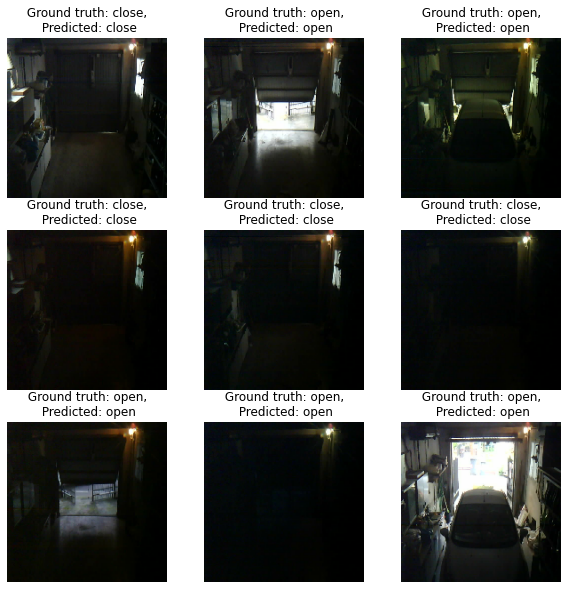

In [17]:
# Predict the labels of digit images in our test dataset.
predictions = model.predict(test_ds)

g = next(test_ds.as_numpy_iterator())

images = g[0] 
labels = g[1] 


n_images = 9
index = random.sample(range(len(labels)), n_images)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(images[index[i]].astype("uint8"))
  plt.title(f" Ground truth: {class_names[int(labels[index[i]])]}, \n Predicted: {class_names[np.argmax(predictions[index[i]])]}")
  plt.axis("off")


# Then plot the first 25 test images and their predicted labels.
#show_sample(val_ds, ['Predicted: %d' % np.argmax(result) for result in predictions])

In [18]:
from sklearn.metrics import confusion_matrix

m = confusion_matrix(labels,np.argmax(predictions, axis=1))
print(m)

[[11  0]
 [ 0 10]]


## Convert the Keras model to TensorFlow Lite

In [19]:
# Convert Keras model to TF Lite format.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TF Lite model as file
f = open('/content/gdrive/My Drive/Colab Notebooks/cnn_garage/model.tflite', "wb")
f.write(tflite_model)
f.close()

INFO:tensorflow:Assets written to: /tmp/tmpnjo8liwv/assets


In [20]:
# Download the digit classification model if you're using Colab, 
# or print the model's local path if you're not using Colab.
try:
  from google.colab import files
  files.download('/content/gdrive/My Drive/Colab Notebooks/cnn_garage/model.tflite')
except ImportError:
  import os
  print('TF Lite model:', os.path.join(os.getcwd(), '/content/gdrive/My Drive/Colab Notebooks/cnn_garage/model.tflite'))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Verify the TensorFlow Lite model

In [21]:
# Helper function to display digit images
import math
def show_sample(images, labels, sample_count=25):
  # Create a square with can fit {sample_count} images
  grid_count = math.ceil(math.ceil(math.sqrt(sample_count)))
  grid_count = min(grid_count, len(images), len(labels))
  
  plt.figure(figsize=(2*grid_count, 2*grid_count))
  for i in range(sample_count):
    plt.subplot(grid_count, grid_count, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap=plt.cm.gray)
    plt.xlabel(labels[i])
  plt.show()

(1, 180, 180, 3)


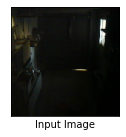

In [22]:
# Load a test image
zero_img_path = tf.keras.utils.get_file(
    origin='/content/gdrive/My Drive/Colab Notebooks/cnn_garage/test/close/test.jpg',
    fname='/content/gdrive/My Drive/Colab Notebooks/cnn_garage/test/close/test.jpg'
)
image = tf.keras.preprocessing.image.load_img(
    zero_img_path,
    target_size=(180, 180),
)

# In training, we feed images in a batch to the model to improve training speed, making the model input shape to be (BATCH_SIZE, 180, 180).
# For inference, we still need to match the input shape with training, so we expand the input dimensions to (1, 180, 180) using np.expand_dims
input_image = np.expand_dims(np.array(image, dtype=np.float32), 0)
print(input_image.shape)

# Show the pre-processed input image
show_sample(input_image/255, ['Input Image'], 1)

In [25]:
# Run inference with TensorFlow Lite
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()
interpreter.set_tensor(interpreter.get_input_details()[0]["index"], input_image)
interpreter.invoke()
output = interpreter.tensor(interpreter.get_output_details()[0]["index"])()[0]

# Print the model's classification result
digit = np.argmax(output)
print(f'Predicted label: {digit}\nConfidence: {output[digit]}\n{output}')

Predicted label: 0
Confidence: 4.902035236358643
[ 4.902035  -1.4189473]
